# pytorch 基础

本课内容包括
1. 基本的pytorch入门
2. pytorch中向量、导数、偏导操作，参考之前线性代数以及微积分
3. 基于pytorch构建一个线性回归网络
4. 基于pytorch实现class1 对图片的分类以及优化

---

参考资料

1. [ws university pytorch introudction](https://courses.cs.washington.edu/courses/cse446/19au/section9.html)
2. [li hong yi](https://www.youtube.com/watch?v=kQeezFrNoOg)
3. [pytorch homepage](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

## 1.安装pytorch

与tensorflow相同，pytorch分为cpu版本与gpu版本，官网有相对于安装代码
[安装页面](https://pytorch.org/)



参看本地计算机是否支持GPU以及GPU型号

In [2]:
import torch
def pytrochGPU(memoryview=False):
    support=torch.cuda.is_available()
    if support==True:
        print("GPU is available")
        print("GPU的数量",torch.cuda.device_count())
        print("GPU的名字",torch.cuda.get_device_name(0))
        print("当前GPU索引",torch.cuda.current_device())
    else:
        print("only support cpu")
if __name__ == '__main__':
    print(pytrochGPU())


only support cpu
None


由于可能本地计算机没有gpu，为了避免出错，首先判断是GPU还是CPU，并将数据在对应设备上进行运算

In [3]:
import numpy as np
device="cuda" if torch.cuda.is_available() else "cpu"
x=torch.randn(2,3)
x=x.to(device)
print(x.device)


cpu



pytorch 中torch的作用类似numpy，包括创建数组，进行线性代数运算等，但torch还可以直接进行求导运算

numpy 与 torch之间也可以相互转化

例如numpy中创建数组与torch中创建tensor张量对比

```python 
np.array([12,3])
torch.tensor([12,3])
```

1. array与tensor相互转换


In [5]:
import numpy as np 
if __name__ == '__main__':
    x_tensor=torch.tensor([2,3,2])
    print(type(x_tensor))
    print(x_tensor)
    y_array=x_tensor.numpy()#转换tensor到array
    print(type(y_array))
    print(y_array)

    x_arrray=np.array([[2,2,3],[2,2,2]])
    print(type(x_arrray))
    print(x_arrray.shape)
    y_tensor=torch.from_numpy(x_arrray)
    print(type(y_tensor))
    print(y_tensor.shape)

<class 'torch.Tensor'>
tensor([2, 3, 2])
<class 'numpy.ndarray'>
[2 3 2]
<class 'numpy.ndarray'>
(2, 3)
<class 'torch.Tensor'>
torch.Size([2, 3])


2. tensor 中的线性代数计算
tensor中的计算与numpy中基本一致，包括加减，内积,求norm等。

例如以下代码模拟了一个神经网络affine层中的输入值与权参相乘与偏参相加的计算

In [18]:
# 注意，torch在求norm时，要求数据必须为float数据，故在开始就必须制定向量的数据类型
x=torch.tensor([2,3,3],dtype=float)
w=torch.tensor([[2,2],[1,2],[3,2]],dtype=float)
b=torch.tensor([1,2],dtype=float)
z=x@w+b
print(z)
print(torch.norm(z))

tensor([17., 18.], dtype=torch.float64)
tensor(24.7588, dtype=torch.float64)


tensor中正态分布、随机值等的生成与numpy也一致

```python
torch.rand(维度1数，维度2数，维度3数)
```


In [ ]:
x=torch.rand(2,2,2,2)
print(x)
x_a=np.random.rand(2,2,2,2,2)
print(x_a)

tensor 形状改变
* Tensor.view-改变形状
* Tensor.flatten-降维为1维

We can use the Tensor.view() function to reshape tensors similarly to numpy.reshape()

It can also automatically calculate the correct dimension if a -1 is passed in. This is useful if we are working with batches, but the batch size is unknown.
 
 

In [28]:
batch=1000
img_x=28
img_y=28
#生成一个（1000，28，29）形状的张量，模拟1000张28*28图像
x=torch.rand(batch,img_x,img_y)
print(x.shape)
#将x变更为(1000,784)形状的张量
x2=x.view(batch,img_x*img_y)
print(x2.shape)
#当不确定某维度的大小（batch大小），可以设为-1，torch将自动赋值
x3=x.view(batch,-1)
print(x3.shape)
x3=x.view(-1,784)
print(x3.shape)
#将张量降维为1维
x_fallten=torch.flatten(x)
print(x_fallten.shape)


torch.Size([1000, 28, 28])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([1000, 784])
torch.Size([784000])


## Computation graphs 计算图

参考
* [computation graph](https://colah.github.io/posts/2015-08-Backprop/)


What's special about PyTorch's tensor object is that it implicitly creates a computation graph in the background. A computation graph is a a way of writing a mathematical expression as a graph. There is an algorithm to compute the gradients of all the variables of a computation graph in time on the same order it is to compute the function itself.

---

pytorch可以自动实现计算图，Backpropagation反向传播

<img src="figs\tree-def.png" height="50%" width="50%">

例如上图对应计算 $e=(a+b) \times (1+b)$，求$a=1,b=2$时的反向传播

为此，在对tensor复制时候，必须设置**requires_grad=True**从而pytroch将会保留计算图
>we set requires_grad=True to let PyTorch know to keep the graph


In [31]:
a=torch.tensor(1.0,requires_grad=True)
b=torch.tensor(2.0,requires_grad=True)
c=a+b
d=1+b
e=c*d
print(c)
print(d)
print(e)


tensor(3., grad_fn=<AddBackward0>)
tensor(3., grad_fn=<AddBackward0>)
tensor(9., grad_fn=<MulBackward0>)


## PyTorch as an auto grad framework
Now that we have seen that PyTorch keeps the graph around for us, let's use it to compute some gradients for us.

Consider the function  $f(x)=(x−2)^2$
 .

Q: Compute  $\frac{df(x)}{dx}$
  and then compute  $f′(1)$
 .

We make a backward() call on the leaf variable (y) in the computation, computing all the gradients of y at once.

---
1. pytorch 中，张量具有require_grad属性，该属性为True则将跟踪对此张量的所有计算。
2. 完成正向传播计算后，可以对计算结果调用backward（）方法，将自动计算所有梯度，并保存至grad属性中
3. 张量的grad_fn属性将指向运算生成该张量的方法。
通过pytorch中backward可以求得导函数结果


In [38]:
def f(x):
    return (x-2)**2
x=torch.tensor(1.0,requires_grad=True)
y=f(x)
print("正向传播forward:",y)
y.backward()
print("方向传播结果",x.grad)
print(y.grad_fn)


正向传播forward: tensor(1., grad_fn=<PowBackward0>)
方向传播结果 tensor(-2.)


可以设置一个嵌套函数，并求得不同层变量的导数
设
$$y=x^2 \rightarrow z=y+w \rightarrow e=z\times 3+5$$
其中$x=2,w=3$求位于链式求导叶子节点的$\frac{de}{dx},\frac{de}{dw}$

In [47]:
def y(x):
    return x**2
def z(y,w):
    return y+w
def e(z):
    return z*3

if __name__ == '__main__':
    x=torch.tensor(2.0,requires_grad=True)
    w=torch.tensor(3.0,requires_grad=True)
    ##forwad
    y=y(x)
    z=z(y,w)
    e=e(z)
    print("forward result:",e)
    #backward 
    e.backward()
    print("e函数求梯度方法：",e.grad_fn)
    print("y函数求梯度方法：",y.grad_fn)
    print("x的梯度",x.grad)
    print("w的梯度",w.grad)
    

forward result: tensor(21., grad_fn=<MulBackward0>)
e函数求梯度方法： <MulBackward0 object at 0x000002008750C340>
y函数求梯度方法： <PowBackward0 object at 0x000002008750C340>
x的梯度 tensor(12.)
w的梯度 tensor(3.)


It can also find gradients of functions.

Let  $w=[w_1,w_2]^T$
 
Consider  $(w)=2w_1w_2+w_2\cos(w_1)$
 
Q: Compute  $∇wg(w)$
  and verify $ ∇wg([π,1])=[2,π−1]^T$

---

进一步求得偏导数，并构成梯度向量

 

In [51]:
def g(w):
    return 2*w[0]*w[1]+w[1]*torch.cos(w[0])
if __name__ == '__main__':
    w=torch.tensor([torch.pi,1],dtype=float,requires_grad=True)
    print("forwad")
    g=g(w)
    print(g)
    print("backward")
    g.backward()
    print(w.grad)

forwad
tensor(5.2832, dtype=torch.float64, grad_fn=<AddBackward0>)
backward
tensor([2.0000, 5.2832], dtype=torch.float64)


基于以上torch对backward，梯度计算方式，可以结合实现梯度下降法；

---
Using the gradients
Now that we have gradients, we can use our favorite optimization algorithm: gradient descent!

Let  $f$
  the same function we defined above.

Q: What is the value of $ x$
  that minimizes $ f$?

  ---

  注意在此

In [ ]:
def f(x):
    return (x-2)**2

if __name__=='__main__':
    iter=100
    learning_rate=0.8
    x=torch.tensor([100.0],requires_grad=True)
    
    for i in range(iter):
        y=f(x)
        y.backward()
        #计算时，必须使用x.data
        x.data=x.data-(x.grad)*learning_rate
        print(x.data)
        
        x.grad.zero_() 


基于Pytorch建立线性方程

1. 构建基本的线性方程
2. 描述方程各个部分

---
Linear Module 
 
The bread and butter of modules is the Linear module which does a linear transformation with a bias. It takes the input and output dimensions as parameters, and creates the weights in the object.

Unlike how we initialized our  w manually, the Linear module automatically initializes the weights randomly. For minimizing non convex loss functions (e.g. training neural networks), initialization is important and can affect results. If training isn't working as well as expected, one thing to try is manually initializing the weights to something different from the default. PyTorch implements some common initializations in torch.nn.init.

---

pytorch 在linear层将会自动初始化权参、偏参的初始值，通过torch.nn.init 实现。

### torch.optim 优化函数
PyTorch implements a number of gradient-based optimization methods in torch.optim, including Gradient Descent.

 At the minimum, it takes in the model parameters and a learning rate.

Optimizers do not compute the gradients for you, so you must call backward() yourself.

You also must call the optim.zero_grad() function before calling backward() since by default

 PyTorch does and inplace add to the .grad member variable rather than overwriting it.

This does both the detach_() and zero_() calls on all tensor's grad variables.

In [ ]:
import torch as t 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
class LinerModel(nn.Module):
    def __init__(self):
        super(LinerModel, self).__init__()
        self.linear=nn.Linear(in_features=1,out_features=1)
        self.weight=self.linear.weight
        self.bias=self.linear.bias
    
    def forward(self,x):
        return self.linear(x)
    
    def getParamters(self):
        return self.weight,self.bias
if  __name__ == '__main__':
    
 

    #plt.scatter(x,y)
    x_t=t.tensor([[0.50,0.75,1.00,1.25,1.50,1.75,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,4.00,4.25,4.50,4.75,5.00,5.50]]).T
    y_t=t.tensor([[10,  22,  13,  43,  20,  22,  33,  50,  62, 48,  55,  75,  62,  73,  81,  76,  64,  82,  90,  93]]).T
    x_n=x_t.numpy().T
    y_n=y_t.numpy().T
    plt.scatter(x_n,y_n)
    print(x_t.shape)
    linear_module=LinerModel()
    y_pred=linear_module.forward(x_t)
    print("通过一次forwad后得到y predict")
    weight,bias=linear_module.getParamters()
    print("模型中参数：",linear_module.parameters())
    print("初始权参值:",weight)
    print("初始偏参值:",bias)
    ########################实例化损失函数，优化函数########################################
    loss_fn=nn.MSELoss()#定义均方误差函数作为损失函数
    optimizer=t.optim.SGD(linear_module.parameters(),lr=0.001)#使用SGD优化函数，对inear_module.parameters()中权参、偏参进行梯度下降法优化，学习率为0.001
    
    iter=1000
    i=0
    for epoch in range(iter):#循环10000次epoch
        print("第",epoch,"次epoch")
        for x,y in zip(x_t,y_t):#对训练集中每一个值都投入模型运算并求得对应梯度，并运行一次梯度下降，完成一个epoch
            i+=1
            y_predict=linear_module(x_t)
            y_predict=y_predict.to(t.float32)
            y_t=y_t.to(t.float32)
            loss=loss_fn(y_predict, y_t)
            optimizer.zero_grad()#清空上次的梯度积累
            loss.backward()#损失函数进行backward反向传播
            if iter>900:
                
                print("第",i,"次梯度下降后")
                print("模型中权参梯度：",linear_module.weight.grad)
                print("模型中偏参梯度",linear_module.bias.grad)
            optimizer.step()#根据计算得到的梯度开始梯度下降更新即W=W-∇w*learningrate
    
    ################################输出最终优化的权参和偏参##############################################
    print("优化后得到权参、偏参分别为：",list(linear_module.named_parameters()))
    y_predict=linear_module(x_t).detach().numpy()#通过模型进行预测.detach()实现返回一个新的tensor，从当前计算图中分离下来的，但是仍指向原变量的存放位置,不同之处只是requires_grad为false，得到的这个tensor永远不需要计算其梯度，不具有grad。
    plt.scatter(x_n,y_n)
    plt.plot(x_t,y_predict)
    
    

In [110]:
d_in = 3
d_out = 4
linear_module = nn.Linear(1, d_out)

example_tensor = torch.tensor([[1.,2,3]]).T
# applys a linear transformation to the data
transformed = linear_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transormed', transformed.shape)
print()
print('We can see that the weights exist in the background\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)

example_tensor torch.Size([3, 1])
transormed torch.Size([3, 4])

We can see that the weights exist in the background

W: Parameter containing:
tensor([[ 0.7270],
        [ 0.7984],
        [-0.8338],
        [ 0.7386]], requires_grad=True)
b: Parameter containing:
tensor([ 0.5252, -0.5931,  0.0407,  0.5955], requires_grad=True)


模型的改进

以上模型没有加入激活函数，只是一个简单的一层线性全连接网络。

以下改进模型，加入激活层，使用relu激活函数：

---

Activation functions
PyTorch implements a number of activation functions including but not limited to ReLU, Tanh, and Sigmoid. Since they are modules, they need to be instantiated.

---

pytorch中，激活层的使用与之前numpy构建相似，首先实例化一个激活函数，正向传播全连接层input的数据后，得到激活值，传递给下一个全连接层。

In [49]:
relu_fn=nn.ReLU()#实例化Relu函数
x=t.randn(2,dtype=float)
print(x)
print("relu 激活函数很简单，即如果x>0则输出x反之输出0")
y=relu_fn.forward(x)
print(y)



tensor([1.4335, 0.6307], dtype=torch.float64)
relu 季候函数
tensor([1.4335, 0.6307], dtype=torch.float64)


实现将激活函数加入之前线性层之后，注意输出层也必须为一个线性层，而后在外部使用平均误差函数

---
出现问题
1. 单独将数据放入GPU无法训练，还必须将model放入gpu
```python
    x_t=x_t.to(device)#将数据移动到gpu
    y_t=y_t.to(device)#将数据运动到gpu
    linear_module=LinerModel()
    linear_module.to(device)#模型也必须移动到GPU
```
2. 如果想把CUDA tensor格式的数据改成numpy时，需要先将其转换成cpu float-tensor随后再转到numpy格式。 numpy不能读取CUDA tensor 需要将它转化为 CPU tensor
```python
    x_n=x_t.cpu().numpy().T
    y_n=y_t.cpu().numpy().T
```

cuda:0
torch.Size([20, 1])
通过一次forwad后得到y predict
模型中参数： <generator object Module.parameters at 0x7f13dc35bc80>
初始权参值: Parameter containing:
tensor([[-0.1672]], device='cuda:0', requires_grad=True)
初始偏参值: Parameter containing:
tensor([0.2451], device='cuda:0', requires_grad=True)
优化后得到权参、偏参分别为： [('weight', Parameter containing:
tensor([[-2.3126]], device='cuda:0', requires_grad=True)), ('bias', Parameter containing:
tensor([8.8496], device='cuda:0', requires_grad=True)), ('linear2.weight', Parameter containing:
tensor([[-9.1446]], device='cuda:0', requires_grad=True)), ('linear2.bias', Parameter containing:
tensor([80.9977], device='cuda:0', requires_grad=True))]


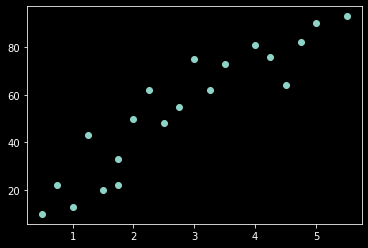

In [15]:
import torch as t 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
class LinerModel(nn.Module):
    def __init__(self):
        super(LinerModel, self).__init__()
        self.linear1=nn.Linear(in_features=1,out_features=1)
        self.relu1=nn.ReLU()
        self.linear2=nn.Linear(in_features=1,out_features=1)
        self.weight=self.linear1.weight
        self.bias=self.linear1.bias
    
    def forward(self,x):
        x=self.linear1(x)
        x=self.relu1(x)
        x=self.linear2(x)
        return x
    
    def getParamters(self):
        return self.weight,self.bias
if  __name__ == '__main__':
    
 

    #plt.scatter(x,y)
    x_t=t.tensor([[0.50,0.75,1.00,1.25,1.50,1.75,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,4.00,4.25,4.50,4.75,5.00,5.50]]).T
    y_t=t.tensor([[10,  22,  13,  43,  20,  22,  33,  50,  62, 48,  55,  75,  62,  73,  81,  76,  64,  82,  90,  93]]).T
    
    device="cuda" if t.cuda.is_available() else "cpu"
    x_t=x_t.to(device)#将数据移动到gpu
    y_t=y_t.to(device)#将数据运动到gpu
    
    print(x_t.device)
    x_n=x_t.cpu().numpy().T
    y_n=y_t.cpu().numpy().T
    print(x_t.shape)
    linear_module=LinerModel()
    linear_module.to(device)#模型也必须移动到GPU
    y_pred=linear_module.forward(x_t)
    print("通过一次forwad后得到y predict")
    weight,bias=linear_module.getParamters()
    print("模型中参数：",linear_module.parameters())
    print("初始权参值:",weight)
    print("初始偏参值:",bias)
    ########################实例化损失函数，优化函数########################################
    loss_fn=nn.MSELoss()#定义均方误差函数作为损失函数
    optimizer=t.optim.SGD(linear_module.parameters(),lr=0.001)#使用SGD优化函数，对inear_module.parameters()中权参、偏参进行梯度下降法优化，学习率为0.001
    
    iter=1000
    i=0
    for epoch in range(iter):#循环10000次epoch
        #print("第",epoch,"次epoch")
        for x,y in zip(x_t,y_t):#对训练集中每一个值都投入模型运算并求得对应梯度，并运行一次梯度下降，完成一个epoch
            i+=1
            y_predict=linear_module(x_t)
            y_predict=y_predict.to(t.float32)
            y_t=y_t.to(t.float32)
            loss=loss_fn(y_predict, y_t)
            optimizer.zero_grad()#清空上次的梯度积累
            loss.backward()#损失函数进行backward反向传播
            if iter>9000:
                
                print("第",i,"次梯度下降后")
                print("模型中权参梯度：",linear_module.weight.grad)
                print("模型中偏参梯度",linear_module.bias.grad)
            optimizer.step()#根据计算得到的梯度开始梯度下降更新即W=W-∇w*learningrate
    
    ################################输出最终优化的权参和偏参##############################################
    print("优化后得到权参、偏参分别为：",list(linear_module.named_parameters()))
    y_predict=linear_module(x_t).detach().cpu().numpy()#通过模型进行预测.detach()实现返回一个新的tensor，从当前计算图中分离下来的，但是仍指向原变量的存放位置,不同之处只是requires_grad为false，得到的这个tensor永远不需要计算其梯度，不具有grad。
    plt.scatter(x_n,y_n)
    plt.plot(x_n,y_predict.T)

基于以上代码，重现华盛顿大学 pytroch课程

首先定义相关的待拟合函数
$$y=4 \times sin(\pi \times x)\times cos(6 \times x^2)$$

并展现相关的图像

torch.Size([200, 1]) torch.Size([200, 1])


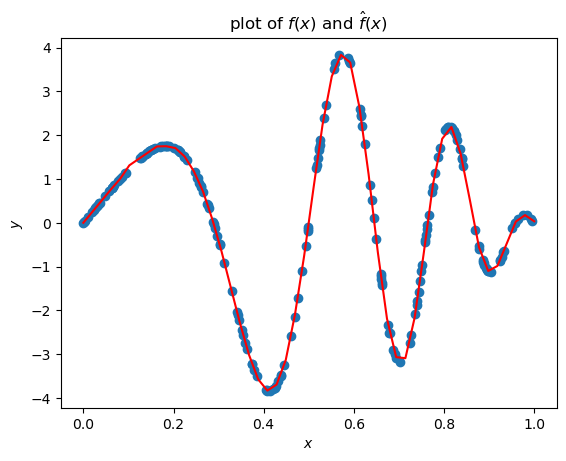

In [16]:
%matplotlib inline
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

class simpleNet(nn.Module):
    def __init__(self,input,output):
        super(simpleNet, self).__init__()
        self.linear1=nn.Linear(in_features=input, out_features=200)
        self.relu1=nn.ReLU()
        self.linear2=nn.Linear(in_features=200, out_features=300)
        self.relu2=nn.ReLU()
        self.linear3=nn.Linear(in_features=300, out_features=output)
    
    def forward(self, x):
        x=self.linear1(x)
        x=self.relu1(x)
        x=self.linear2(x)
        x=self.relu2(x)
        x=self.linear3(x)
        return x
if __name__=='__main__':
    

    d = 1
    n = 200
    X = torch.rand(n,d)
    iterm=50000
    y = 4 * torch.sin(np.pi * X) * torch.cos(6*np.pi*X**2)
    print(X.shape, y.shape)
 
################################################################
    net=simpleNet(input=d,output=d)
    loss_fn=nn.MSELoss()
    opt=torch.optim.Adam(params=net.parameters(),lr=0.01)
    for epoch in range(iterm):
         
            y_pred=net.forward(X)
            loss=loss_fn(y_pred,y)
            opt.zero_grad()
            loss.backward()
            opt.step()#更新权参、偏参
    
    X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
    y_hat = net(X_grid)
    plt.scatter(X.numpy(), y.numpy())
    plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
    plt.title('plot of $f(x)$ and $\hat{f}(x)$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.show()

Sequential
---
除了使用创建modle类，再进行模型训练方法，也可以通过Sequenltal将模型串联，开始运算，但这种方式正规性不强，与tensorflow类似。
但是可以将Sequential集成到modle类中，实现序列包装，并在forwrd中直接调用，可以避免出错。

```python
class Net(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ReLU(),
            nn.Linear(hidden_num, output_num),
            nn.ReLU()
        )

    def forward(self, input):
        return self.net(input)
 
```
__init__ 方法中不为每一层显式地创建一个实例类层，同时在forward中直接调用Squential对象进行运算即可。

Many times, we want to compose Modules together. torch.nn.Sequential provides a good interface for composing simple modules.

## 实验
### 实验1 多元函数
在以上案例基础上，进一步实现多元回归的神经网络，包括
1. 数据获取
2. 数据观察
3. 对数据的标准化
4. 实现mini-batch载入
5. 通过train、test数据划分验证数据
6. 结合之前知识，实验模型优化
总之，实现一个完整的面向数值多元数据的神经网络构建流程

参考
* [神经网络多元回归](https://blog.csdn.net/qq_39567427/article/details/111935833)

In [19]:
!pip install torchsummary

载入数据，进行基本数据观察，数据来源于sklearn

----
注意层数与神经元确定个数：

[参考](https://zhuanlan.zhihu.com/p/100419971)

载入数据tpye <class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])
自变量多元数据：
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
[[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
  4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00]]
自变量数据类型： <class 'numpy.ndarray'> 数据形状： (506, 13)
因变量数据类型： <class 'numpy.ndarray'> 数据形状： (506, 1)
训练集形状 (303, 13) (303, 1)
测试集形状 (203, 13) (203, 1)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 15]             210
              ReLU-2                   [-1, 15]               0
            Linear-3                   [-1, 15]             240
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
              ReLU-6                    [-1, 1]   

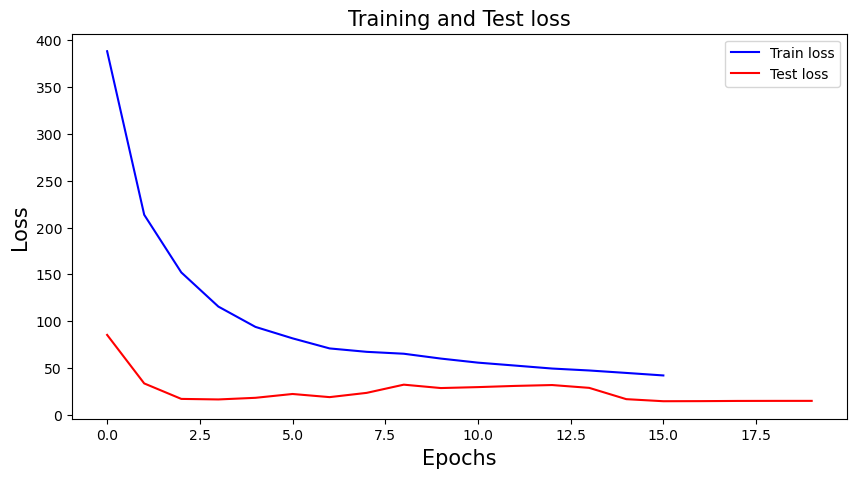

(203, 1)
(203, 1)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202]


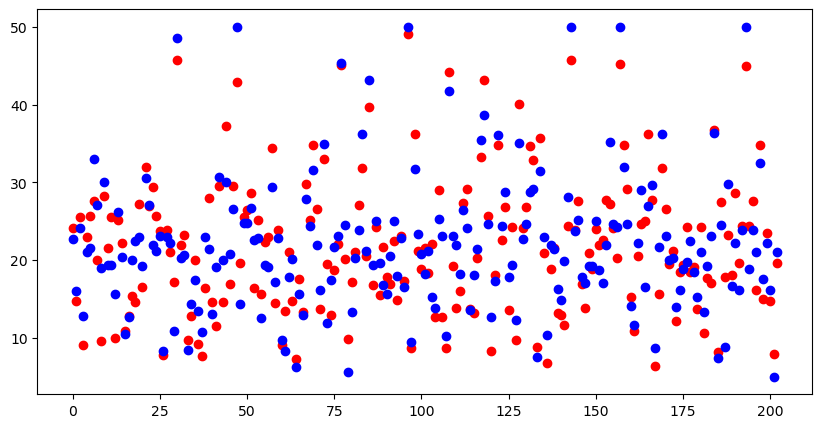

In [48]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from torch import nn
import torch
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
from sklearn.preprocessing import scale
from torchsummary import summary
from matplotlib.font_manager import FontProperties

class MyNet(nn.Module):
    def __init__(self,input,output) -> None:
        super(MyNet, self).__init__()
        self.nn=nn.Sequential(
            nn.Linear(in_features=13,out_features=15),
            nn.ReLU(),
            nn.Linear(in_features=15,out_features=15),
            nn.ReLU(),
            nn.Linear(in_features=15,out_features=1),
            nn.ReLU()
        )
        #self.linear1=nn.Linear(in_features=13,out_features=20)
        #self.relu1=nn.ReLU()
        #self.linear2=nn.Linear(in_features=20,out_features=1)
        #self.relu2=nn.ReLU()
        
    def forward(self,x):
        return self.nn(x)
        #x=self.linear1(x)
        #x=self.relu1(x)
        #x=self.linear2(x)
        #x=self.relu2(x)
        
        return x

if __name__ == '__main__':
    if boston is None:
       boston = load_boston()
    print("载入数据tpye",type(boston))
    #获取数据键
    print(boston.keys())
    #print("数据集描述：",boston['DESCR'])
    print("自变量多元数据：")
    print(boston['feature_names'])
    print(boston['data'][0:1])
    #print("因变量：")
    #print(boston['target'])
    ################################################################
    #数据划分#
    x=boston['data']
    print("自变量数据类型：",type(x),"数据形状：",x.shape)
    y=boston['target'].reshape(-1,1)
    print("因变量数据类型：",type(y),"数据形状：",y.shape)
    ################################################################
    #数据预处理#
    ## 1. 标准化因变量#，在此标准化非常重要，没有标准化得到模型基本不能使用
    scaler=StandardScaler()
    x=scaler.fit_transform(x)
    ## 2. 数据打乱顺序
    x,y=shuffle(x,y)
    ## 3. 划分train，test
    x_size=x.shape[0]
    trian_size=int(x_size*0.6)
    x_train,x_test,y_train,y_test=x[0:trian_size,:],x[trian_size:,:],y[0:trian_size,:],y[trian_size:,:]
    print("训练集形状",x_train.shape,y_train.shape)
    print("测试集形状",x_test.shape,y_test.shape)
    #数据载入tensor
    ## 1.转换numpy到tensor张量
    x_train =torch.from_numpy(x_train)
    y_train =torch.from_numpy(y_train)
    x_test =torch.from_numpy(x_test)
    y_test =torch.from_numpy(y_test)
    ## 判断cuda是否可用，选择gpu或cpu载入数据处理
    device="cuda" if torch.cuda.is_available() else "cpu"
    x_train.to(device)
    y_train.to(device) 
    x_test.to(device) 
    y_test.to(device)
    x_train=x_train.to(torch.float32)
    y_train=y_train.to(torch.float32)
    x_test=x_test.to(torch.float32)
    y_test=y_test.to(torch.float32)
    ################################################################
    ## 1. 构建模型实例,注意要载入gpu或cpu中与数据对应,summary输出网络的结构信息
    net=MyNet(input=13,output=1).to(device)
    summary(net, input_size=(13,))
    
    ## 2.超参设置
    learning_rate=0.02
    epochs=20
    batch_size=20
    total_steps=int(x_train.shape[0]/batch_size)
    print("完成一个epoch，需要读取",total_steps,"个batchs")
    ## 3.创建损失函数，优化函数实例
    loss_fn=nn.MSELoss()
    opt=torch.optim.Adam(params=net.parameters(),lr=learning_rate)
    ## 4.创建list记录训练loss，以及最后的test loss，作为对比
    train_loss_list=[]
    test_loss_list=[]
    train_acc_list=[]
    test_acc_list=[]
    step_loss=[]
    ## 4.训练模型
    for step in range(epochs):#循环1000个epochs
        print("epoch：",step)
        for i in range(total_steps):#内部完成基于batch的一个epochs数据读取
            x_train_batch=x_train[step * batch_size:(step + 1) * batch_size, :]
            y_train_batch=y_train[step * batch_size:(step + 1) * batch_size, :]
            #y_train=y_train.to(torch.float32)
            #x_train=x_train.to(torch.float32)
            y_pred=net(x_train_batch)
            loss=loss_fn(y_pred,y_train_batch)
            #print(loss.cpu().detach().numpy())
            step_loss.append(loss.cpu().detach().numpy())#记录每一个batch的loss值
            opt.zero_grad()
            loss.backward()
            opt.step()
       
        train_loss=np.mean(step_loss)#计算每一个epoch的平均loss
        train_loss_list.append(train_loss)
        y_predict=net(x_test)
        test_loss=loss_fn(y_predict, y_test)
        test_loss_list.append(test_loss.cpu().detach().numpy())
        print('#####################')
        print("第",step,"个epoch")
        print("train loss:",train_loss)
        print("test loss:",test_loss)
        
    fig = plt.gcf()
    fig.set_size_inches(10, 5)

    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.plot(train_loss_list, 'blue', label='Train loss')
    plt.plot(test_loss_list, 'red', label='Test loss')
    plt.legend(loc='best')
    plt.title('Training and Test loss', fontsize=15)
    plt.show()
    ################################################################
    # 通过x_test预测数据并与实际值对比
    y_predict=net.forward(x_test)
    y_pred=y_predict.cpu().detach().numpy()
    y_t=y_test.cpu().detach().numpy()
    print(y_pred.shape)
    print(y_t.shape)
    predciton=np.arange(len(y_pred))
    print(predciton)
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    plt.scatter(predciton,y_pred,color='red')
    plt.scatter(predciton,y_t,color='blue')
    

### 实验2 图像分类（from numpy）
该实验对之前numpy版本的深度学习网络进行pytorch实现，其中数据载入、建议使用之前的方法，而非pytorch方法，在进阶实验中换为pytorch的
Dataloder()
 


In [23]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import load_data as l
from matplotlib import pyplot as plt
import numpy as np 
from torchsummary import summary
class MNet(nn.Module):
    def __init__(self,input,hidden,output) -> None:
        super(MNet,self).__init__()
        self.nn=nn.Sequential(
            nn.Linear(in_features=input,out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden,out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden,out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden,out_features=output),
            nn.Softmax()
        )
    def forward(self,x):
        return self.nn(x)
    
    def accuracy(self, x, t):
        y = self.forward(x)
        y = torch.argmax(y, axis=1)
        #if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = torch.sum(y == t) / torch.FloatTensor(x.shape[0])
        return accuracy

if __name__ == '__main__':
    ################################数据载入、数据预处理################################
    #对所有数据进行 normalization
    stdsc=StandardScaler()
    (x_train,t_train),(x_test,t_test)=l.load_mnist(normalize=True,one_hot_label=True,flatten=True)#flatten是否将矩阵变为一维数组
    print(x_train.shape,t_train.shape)

    x_train=stdsc.fit_transform(x_train)
    x_test=stdsc.fit_transform(x_test)
    train_size=x_train.shape[0]# 获取行数
    train_loss_list=[]
    test_lost_list=[]
    train_acc_list=[]
    test_acc_list=[]
    ################################numpy数据张量化，并载入本机gpu或cpu################################`
    x_train=torch.from_numpy(x_train).to(torch.float32)
    t_train=torch.from_numpy(t_train).to(torch.float32)
    x_test=torch.from_numpy(x_test).to(torch.float32)
    t_test=torch.from_numpy(t_test).to(torch.float32)
    device="cuda" if torch.cuda.is_available() else "cpu"
    x_train.to(device)
    x_test.to(device)
    t_test.to(device)
    t_train.to(device)
    ## 超参设定
    learning_rate=0.09#学习率
    batch_size=100# 每批次随机选取100张图像
    epochs=1000#循环epoch次数
    steps=int(x_train.shape[0]//batch_size)#完成一个epoch需要读取多少次batch
    print(steps)
    ################################网络实例构建################################
    #构建网络实例，注意在网络实例化时，权参、偏参也赋予了初始值
    net=MNet(input=int(x_train.shape[1]),hidden=40,output=10)
    loss_fn=nn.CrossEntropyLoss()
    opt=torch.optim.Adam(params=net.parameters(),lr=learning_rate)
    summary(net,input_size=(784,))
    ################################网络实例训练################################
    for epoch in range(epochs):
        print("第{}次epoch".format(epoch))
        for step in range(steps):
            x=x_train[step*batch_size:(step+1)*batch_size,:]
            y=t_train[step*batch_size:(step+1)*batch_size,:]
            y_pred=net(x)
            print(y_pred)
            loss=loss_fn(y_pred,y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            if step%iter_per_epoch==0:
                train_loss=network.loss(x_train,t_train)
                train_loss_list.append(train_loss)
                test_loss=network.loss(x_test,t_test)
                test_lost_list.append(test_loss)
                
                train_acc=network.accuracy(x_train,t_train)
                test_acc=network.accuracy(x_test,t_test)
                train_acc_list.append(train_acc)
                test_acc_list.append(test_acc)
                print("第",i,"次梯度下降")
                print(i/iter_per_epoch,"个epoch后,训练集的精度为：",train_acc,"测试集的精度为：",test_acc)
            
            
 
    
    
    
    
    
    
    
 

(60000, 784) (60000, 10)
600
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 40]          31,400
              ReLU-2                   [-1, 40]               0
            Linear-3                   [-1, 40]           1,640
              ReLU-4                   [-1, 40]               0
            Linear-5                   [-1, 40]           1,640
              ReLU-6                   [-1, 40]               0
            Linear-7                   [-1, 10]             410
           Softmax-8                   [-1, 10]               0
Total params: 35,090
Trainable params: 35,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.14
----------------------------------------------------------------
第0次epoch
tensor

c:\Users\tom\anaconda3\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000

KeyboardInterrupt: 

In [24]:
import torch
a = torch.tensor(
              [
                  [1, 5, 5, 2],
                  [9, -6, 2, 8],
                  [-3, 7, -9, 1]
              ])
b = torch.argmax(a, dim=0)
print(b)
print(a.shape)


tensor([1, 2, 0, 1])
torch.Size([3, 4])
